In [4]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import numpy as np


In [1]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
num_words=10000)


17464789/17464789 [==============================] - 9s 1us/step


**Data Overview** 

Data is composed on reviews and labels:

The reviews are lists of integers, and each integer maps to a word. This dataset only encodes the top 10,000 most frequent words in the dataset, so there are 10,000 possible integer inputs.

For each review there is a label, which is simply a 0 or 1. 0 means the review is negative and 1 means the review is positive.

There are 50,000 highly polarized reviews from OMDB, which are split into 25,000 training reviews and 25,000 testing reviews. Both training and testing sets are 50% positive and 50% negative.


In [10]:
test_data[4]


[1,
 40,
 49,
 85,
 84,
 1040,
 146,
 6,
 783,
 254,
 4386,
 337,
 5,
 13,
 447,
 14,
 500,
 10,
 10,
 14,
 500,
 517,
 1076,
 357,
 21,
 1684,
 72,
 45,
 290,
 12,
 17,
 515,
 17,
 25,
 380,
 129,
 3305,
 4,
 2191,
 26,
 253,
 5,
 2,
 36,
 80,
 4357,
 25,
 2,
 129,
 330,
 505,
 8,
 2,
 146,
 24,
 3988,
 14,
 500,
 9,
 82,
 2,
 5,
 9,
 1293,
 224,
 10,
 10,
 8,
 401,
 14,
 1361,
 879,
 13,
 28,
 8,
 401,
 61,
 1642,
 2925,
 44,
 1373,
 21,
 591,
 353,
 14,
 500,
 4092,
 30,
 290,
 12,
 10,
 10,
 65,
 790,
 790,
 206,
 158,
 300,
 45,
 15,
 52,
 2,
 158,
 692,
 2,
 158,
 856,
 158]

In [5]:
word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value,key) for (key,value) in word_index.items()])
decoded_review = " ".join(
    [reverse_word_index.get(i-3, "?") for i in train_data[0]])


1641221/1641221 [==============================] - 1s 1us/step


In [8]:
def decode_review(reverse_word_index, dataset, review_index):
    decoded_review = " ".join(
        [reverse_word_index.get(i-3, '?') for i in dataset[review_index]])
    return decoded_review


In [9]:
decode_review(reverse_word_index, test_data, 4)


"? like some other people wrote i'm a die hard mario fan and i loved this game br br this game starts slightly boring but trust me it's worth it as soon as you start your hooked the levels are fun and ? they will hook you ? your mind turns to ? i'm not kidding this game is also ? and is beautifully done br br to keep this spoiler free i have to keep my mouth shut about details but please try this game it'll be worth it br br story 9 9 action 10 1 it's that good ? 10 attention ? 10 average 10"

**Vectorize the data**

Each review only retains a word if it is one of the 10,000 most common words in the dataset. This means for each review there are 10,000 possible values that appear at different frequencies. One way to make this data into a set of consistent input tensors is to vecotrize it.

For each review, create a vector of shape (10000, 1) and multi-hot encode the words that appear. Each value in the vector corresponds to one of the 10,000 possible words. It will have a value of 0 if the word is not present in the review and 1 if it is. 

Vectorizing the data like this turns each review from a list of varying size to an array of consistently shaped vecotrs. The neural net can then batch and process the data in the same, consistent way

*Could make this more interesting by recording frequency of words for each review. Could add a second row, turning input data from vector to a matrix of shape (10000, 2). The first column is a simple multi-hot encoding of if the word is in the review and the second is a float input for the number of times it appears divided by the total number of words in the review (num_appearances / review_length) which gives an idea of how prevalent a word is. May return and try this later to see if it makes a difference on the model accuracy.*


In [11]:
import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    #sequences is an array of arrays. The internal array is a list of integers that map to a word that appears in the review.
    results = np.zeros((len(sequences), dimension)) #initializes an all-zero matrix of shape (len(sequences), dimension) 
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i,j] = 1. #period makes this integer a float
            #this iterates through integers in input array and treats them as indeces in the vectorized output. 
            #for each integer input, the corresponding vector index is encoded with a 1. The rest remain a 0.
    return results #an array of "vector" arrays


In [12]:
x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)


In [13]:
x_test[4]


array([0., 1., 1., ..., 0., 0., 0.])

In [15]:
#We want to vectorize out labels as numpy arrays. Labels are already binary inputs (0 or 1) so just need to turn 
#them into arrays of float32 values.
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')


**Model Architecture**

This is a simple problem, with vector inputs and binary scalar labels. A good model for this is simply a stack of densly connected layers with relu activations. 

This model with have twi intermediate layers, each with 16 units. Then a third layer that will output the scalar prediction regarding review sentiment.

(Input, vectorized text) => (Dense, units=16) => (Dense, units=16) => (Dense, units=1) => (Output, probability of label "1")


In [25]:
model = keras.Sequential([
    layers.Dense(16, activation='relu'), #recall that relu zeroes out negative values
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid') #sigmoid squashes values to range [0,1] which can be interpreted as probability
]) #recall that activation functions apply non-linear transformations and extend the hypothesis space


**Intuition**

The first integer input is the number of **units** in the layer, a.k.a. the dimensionality of representation apce of the layer. For each relu layer, the tensor operations applied are: output = relu(dot(input, W) + b)

Having 16 units means the weigbt matric **W** will have shape (input_dimension, 16). So the dot product with *W* projects the input data onto a 16-dimensional representation space that then has the bias from *b* and relu activation applied. 

The dimensionality of the representation space restricts the freedom / complexity the model is allowed to apply to the problem. Higher dimensionality means more complex representations for more complex problems (and higher computing cost and opportunity for overfitting).


In [27]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#This establishes what optomizer and loss function to use in the model, as well as what metrics to track


In [28]:
#We need to ensure we set up a validation set for evaluating the model
x_val = x_train[:10000] #this sets aside the first 10,000 values to be used as a validation set
partial_x_train = x_train[10000:] #this sets the remaining 15,000 values as our training set, separate from the validation set
y_val = y_train[:10000]
partial_y_train = y_train[10000:]


In [29]:
#Now we train our model, keeping track of our metics (accuracy) for each epoch:

history = model.fit(partial_x_train, #using training set separated from validation set in above cell
    partial_y_train, 
    epochs=20, #iterate over all samples (reviews) 20 times 
    batch_size=512, #iterate over all samples in mini-batches of 512 samples (reviews)
    validation_data=(x_val, y_val)) #sets the inputs and outputs for our separated validation data to the ones defined in the cell above


Epoch 1/20
30/30 [==============================] - 3s 52ms/step - loss: 0.5185 - accuracy: 0.7853 - val_loss: 0.3910 - val_accuracy: 0.8715
Epoch 2/20
30/30 [==============================] - 0s 14ms/step - loss: 0.3121 - accuracy: 0.9013 - val_loss: 0.3150 - val_accuracy: 0.8812
Epoch 3/20
30/30 [==============================] - 0s 13ms/step - loss: 0.2275 - accuracy: 0.9281 - val_loss: 0.3126 - val_accuracy: 0.8731
Epoch 4/20
30/30 [==============================] - 0s 13ms/step - loss: 0.1784 - accuracy: 0.9423 - val_loss: 0.2740 - val_accuracy: 0.8900
Epoch 5/20
30/30 [==============================] - 0s 14ms/step - loss: 0.1463 - accuracy: 0.9527 - val_loss: 0.2971 - val_accuracy: 0.8793
Epoch 6/20
30/30 [==============================] - 0s 15ms/step - loss: 0.1240 - accuracy: 0.9611 - val_loss: 0.2971 - val_accuracy: 0.8842
Epoch 7/20
30/30 [==============================] - 0s 14ms/step - loss: 0.0994 - accuracy: 0.9715 - val_loss: 0.3246 - val_accuracy: 0.8766
Epoch 8/20
30

In [30]:
#model.fit() returns a history object, which is a dictionary where keys are the metrics "accuracy", "loss", "val_accuracy", and "val_loss"

history_dict = history.history
history_dict.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

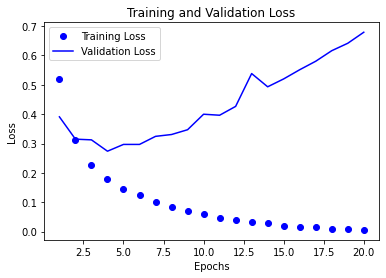

In [37]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, 'bo', label="Training Loss") # 'bo' plots a blue dot
plt.plot(epochs, val_loss_values, 'b', label="Validation Loss") # 'b' plots a solid blue line
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


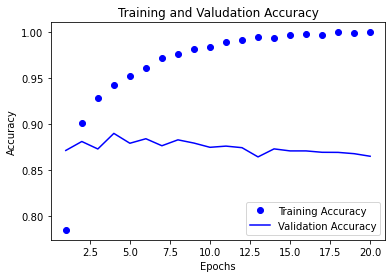

In [38]:
plt.clf() #clears the figure
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Valudation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


**Evaluating Metrics**

Looking at validation accuracy (the most important metric), the accuracy peaked around 4 epi=ochs and then began going down. This is due to *overfitting*. To get better results, retrain a model with only 4 epochs.


In [40]:
model = keras.Sequential([
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train, partial_y_train, epochs=4, batch_size=512, validation_data=(x_val, y_val))


Epoch 1/4
30/30 [==============================] - 2s 49ms/step - loss: 0.5183 - accuracy: 0.7777 - val_loss: 0.3727 - val_accuracy: 0.8770
Epoch 2/4
30/30 [==============================] - 0s 15ms/step - loss: 0.3012 - accuracy: 0.8987 - val_loss: 0.3024 - val_accuracy: 0.8858
Epoch 3/4
30/30 [==============================] - 0s 14ms/step - loss: 0.2197 - accuracy: 0.9284 - val_loss: 0.2841 - val_accuracy: 0.8873
Epoch 4/4
30/30 [==============================] - 0s 13ms/step - loss: 0.1773 - accuracy: 0.9383 - val_loss: 0.2767 - val_accuracy: 0.8879


In [47]:
#can use model.predict() to generate likelihood of reviews being positive:

pred_probs = model.predict(x_test)
preds = np.zeros((len(x_test), 1))
for index, prob in enumerate(pred_probs):
    if prob > 0.5:
        preds[index] = 1


782/782 [==============================] - 1s 1ms/step


In [53]:
results = model.evaluate(x_test, y_test) #returns a list of 2 values, test loss and test accuracy
print('Test set accuracy: ' + str(results[1]))
print('Number of positive reviews: ' + str(sum(preds)))
print('Number of negative reviews: ' + str((len(preds) - sum(preds))))
print('Total number of reviews: ' + str(len(preds)))


782/782 [==============================] - 1s 1ms/step - loss: 0.2972 - accuracy: 0.8794
Test set accuracy: 0.8794000148773193
Number of positive reviews: [11895.]
Number of negative reviews: [13105.]
Total number of reviews: 25000
